# Remaining useful life (RUL) prediction

For more info about the data set, see
https://www.kaggle.com/datasets/ignaciovinuales/battery-remaining-useful-life-rul

"The Hawaii Natural Energy Institute examined 14 NMC-LCO 18650 batteries with a nominal capacity of 2.8 Ah, which were cycled over 1000 times at 25°C with a CC-CV charge rate of C/2 rate and discharge rate of 1.5C.

From that source dataset, I created features that showcase the voltage and current behaviour over each cycle. Those features can be used to predict the remaining useful life (RUL) of the batteries. The dataset contains the summary of the 14 batteries."

In [989]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,  r2_score
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt

In [990]:
%matplotlib inline

In [991]:
df = pd.read_csv("data/Battery_RUL.csv")
df.head()

,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL
0,1.0,2595.30,1151.488500,3.670,3.211,5460.001,6755.01,10777.82,1112
1,2.0,7408.64,1172.512500,4.246,3.220,5508.992,6762.02,10500.35,1111
2,3.0,7393.76,1112.992000,4.249,3.224,5508.993,6762.02,10420.38,1110
3,4.0,7385.50,1080.320667,4.250,3.225,5502.016,6762.02,10322.81,1109
4,6.0,65022.75,29813.487000,4.290,3.398,5480.992,53213.54,56699.65,1107


In [992]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15064 entries, 0 to 15063
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Cycle_Index                15064 non-null  float64
 1   Discharge Time (s)         15064 non-null  float64
 2   Decrement 3.6-3.4V (s)     15064 non-null  float64
 3   Max. Voltage Dischar. (V)  15064 non-null  float64
 4   Min. Voltage Charg. (V)    15064 non-null  float64
 5   Time at 4.15V (s)          15064 non-null  float64
 6   Time constant current (s)  15064 non-null  float64
 7   Charging time (s)          15064 non-null  float64
 8   RUL                        15064 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.0 MB


In [993]:
def split_by_device(df, num_test_devices):
    # This is time series data without and id column for the battery, but we can use the fact that
    # cycle index is reset to 1 for each battery to generate a device id 
    df["split"] = df["Cycle_Index"] == 1.0
    df["device_id"] = df["split"].cumsum()

    # We probably want to include the full life cycle of some devices into the train dataset to be able
    # to learn to predict remaing useful life. Shuffle which devices are in the train and test.
    devices = df["device_id"].unique()
    np.random.shuffle(devices)

    train_devices = devices[num_test_devices:]
    test_devices = devices[:num_test_devices]

    train = df[df['device_id'].isin(train_devices)]
    test = df[df['device_id'].isin(test_devices)]

    return train, test

In [994]:
# Lets take a look at the training data. We leave the test data untouched.
train, test = split_by_device(df, num_test_devices=3)

In [995]:
label = 'RUL'

<Axes: xlabel='Cycle_Index', ylabel='RUL'>

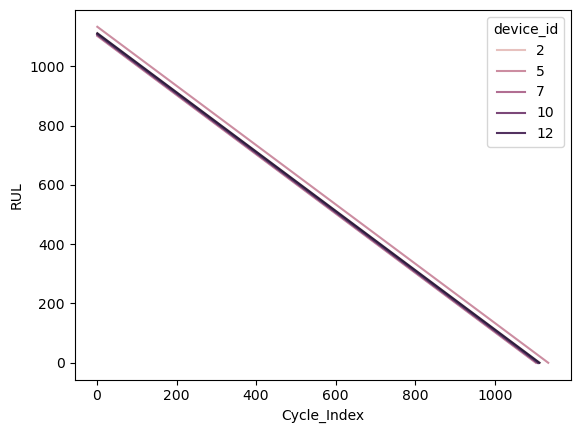

In [996]:
# Remaining useful life is linear, negatively correleated, with the number of cycles. It is not entirely sure that
# cycle index will be available at inference time so we will remove this column before training a model.
# For now it is useful for plotting though.
sns.lineplot(x=train['Cycle_Index'], y=train[label], hue=train['device_id'])

<Axes: xlabel='Cycle_Index', ylabel='Max. Voltage Dischar. (V)'>

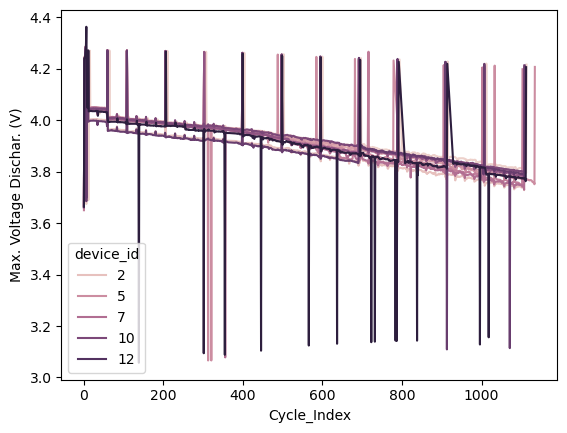

In [997]:
# A spiky negative trend here, looks useful
sns.lineplot(x=train['Cycle_Index'], y=train['Max. Voltage Dischar. (V)'], hue=train['device_id'])

<Axes: xlabel='Cycle_Index', ylabel='Min. Voltage Charg. (V)'>

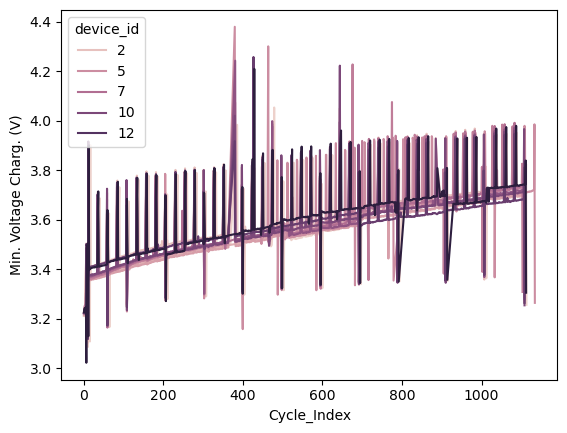

In [998]:
# A spiky positive trend here, looks useful
sns.lineplot(x=train['Cycle_Index'], y=train['Min. Voltage Charg. (V)'], hue=train['device_id'])

In [999]:
# A few signals look like they have extreme outliers:
# - Decrement 3.6-3.4V (s)
# - Discharge Time (s)
# - Time at 4.15V (s)
# - Time constant current (s)
# - Charging time (s)

<Axes: xlabel='Cycle_Index', ylabel='Time at 4.15V (s)'>

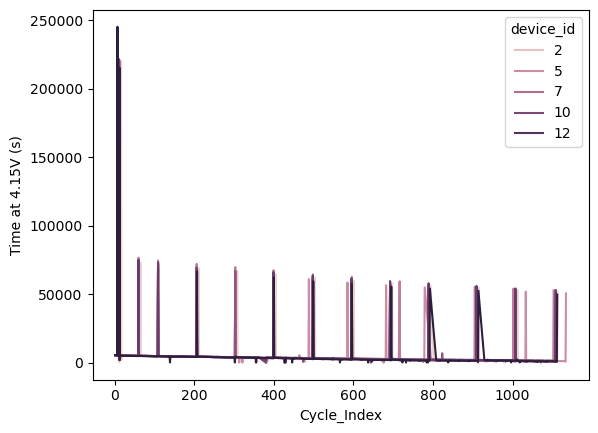

In [1000]:
sns.lineplot(x=train['Cycle_Index'],
             y=train['Time at 4.15V (s)'], hue=train['device_id'])


<Axes: xlabel='Cycle_Index', ylabel='Time constant current (s)'>

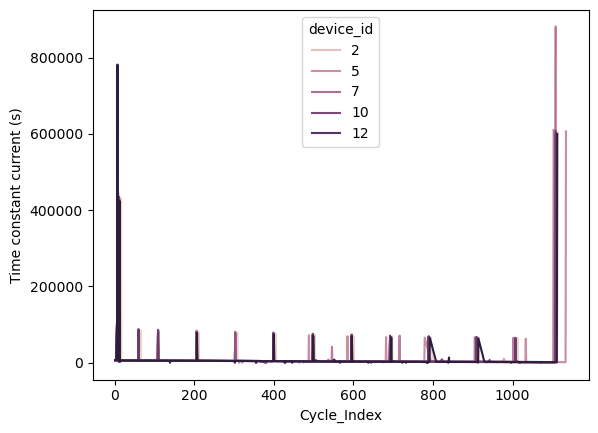

In [1001]:
sns.lineplot(x=train['Cycle_Index'],
             y=train['Time constant current (s)'], hue=train['device_id'])

<Axes: xlabel='Cycle_Index', ylabel='Charging time (s)'>

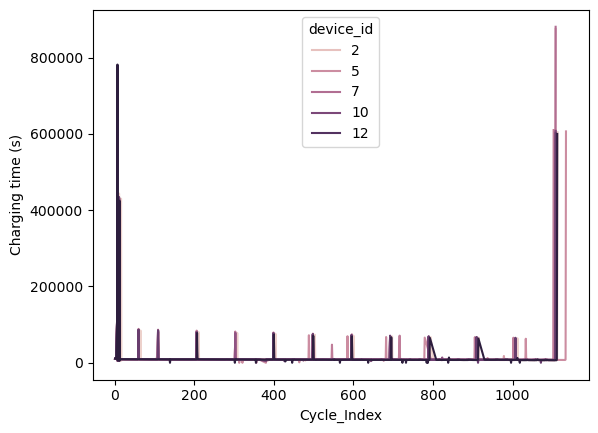

In [1002]:
sns.lineplot(x=train['Cycle_Index'], y=train['Charging time (s)'], hue=train['device_id'])

<Axes: xlabel='Cycle_Index', ylabel='Discharge Time (s)'>

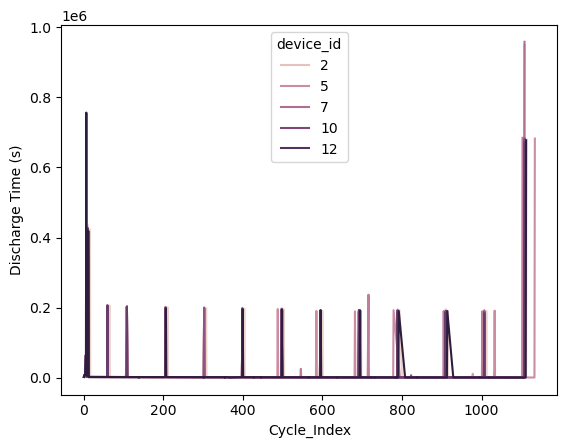

In [1003]:
sns.lineplot(x=train['Cycle_Index'], y=train['Discharge Time (s)'], hue=train['device_id'])

<Axes: xlabel='Cycle_Index', ylabel='Decrement 3.6-3.4V (s)'>

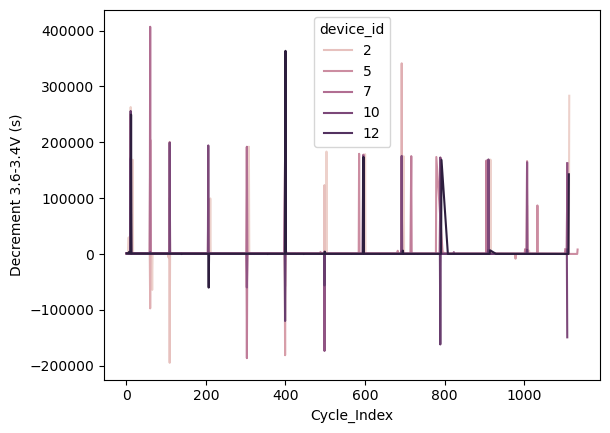

In [1004]:
sns.lineplot(x=train['Cycle_Index'], y=train['Decrement 3.6-3.4V (s)'], hue=train['device_id'])

<Axes: xlabel='Cycle_Index', ylabel='Log Time constant current (s)'>

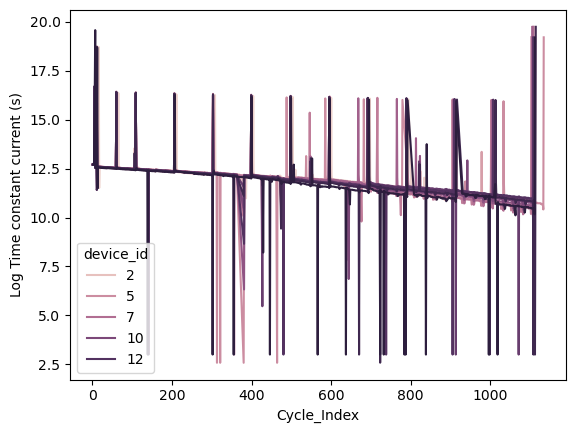

In [1005]:
# It is probably not ok to remove outliers, but transforming them to log scale could make the
# effect of outliers smaller. We have an issue though: some of the columns contain negative values
# and log is not defined there. These are 'Decrement 3.6-3.4V (s)' and 'Time at 4.15V (s)'.
# Still, we can see if the ones without negative values show a better correlation with RUL and
# might be useful for the model training.

df_tmp = df[[
    'Time constant current (s)',
    'Decrement 3.6-3.4V (s)',
    'Discharge Time (s)',
    'Time at 4.15V (s)',
    'Charging time (s)',
    'Cycle_Index',
    'device_id'
]].copy()

df_tmp['Log Time constant current (s)'] = np.log2(df_tmp['Time constant current (s)'])
df_tmp['Log Discharge Time (s)'] = np.log2(df_tmp['Discharge Time (s)'])
df_tmp['Log Charging time (s)'] = np.log2(df_tmp['Charging time (s)'])

sns.lineplot(x=df_tmp['Cycle_Index'],
             y=df_tmp['Log Time constant current (s)'], hue=df_tmp['device_id'])

<Axes: xlabel='Cycle_Index', ylabel='Log Discharge Time (s)'>

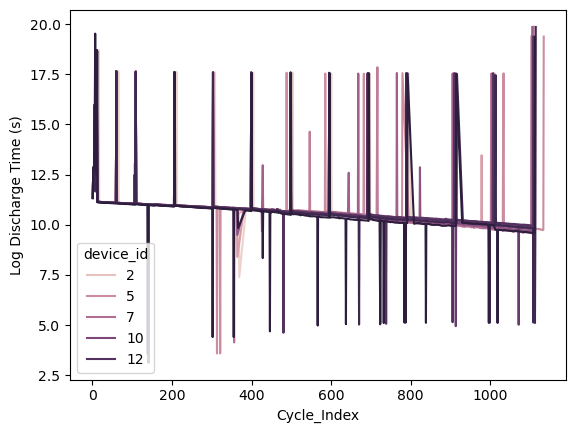

In [1006]:
sns.lineplot(x=df_tmp['Cycle_Index'],
             y=df_tmp['Log Discharge Time (s)'], hue=df_tmp['device_id'])

<Axes: xlabel='Cycle_Index', ylabel='Log Charging time (s)'>

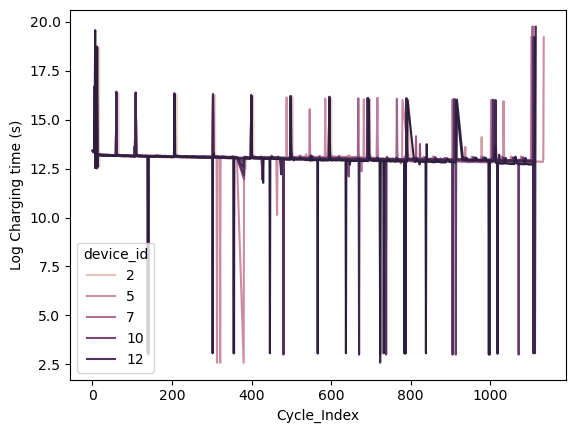

In [1007]:
sns.lineplot(x=df_tmp['Cycle_Index'],
             y=df_tmp['Log Charging time (s)'], hue=df_tmp['device_id'])

In [1008]:
def preprocess(data):
    cols = [col for col in data.columns if col != label]
    data_copy = data[cols].copy()
    data_copy['Log Time constant current (s)'] = np.log2(data_copy['Time constant current (s)'])
    data_copy['Log Discharge Time (s)'] = np.log2(data_copy['Discharge Time (s)'])
    data_copy['Log Charging time (s)'] = np.log2(data_copy['Charging time (s)'])
    
    # adjust label to be last column
    data_copy[label] = data[label].copy()
    return data_copy

train = preprocess(data=train)
test = preprocess(data=test)

In [1009]:
drop_cols = ["Cycle_Index", "split", "device_id"]
train = train.drop(drop_cols, axis=1)
test = test.drop(drop_cols, axis=1)

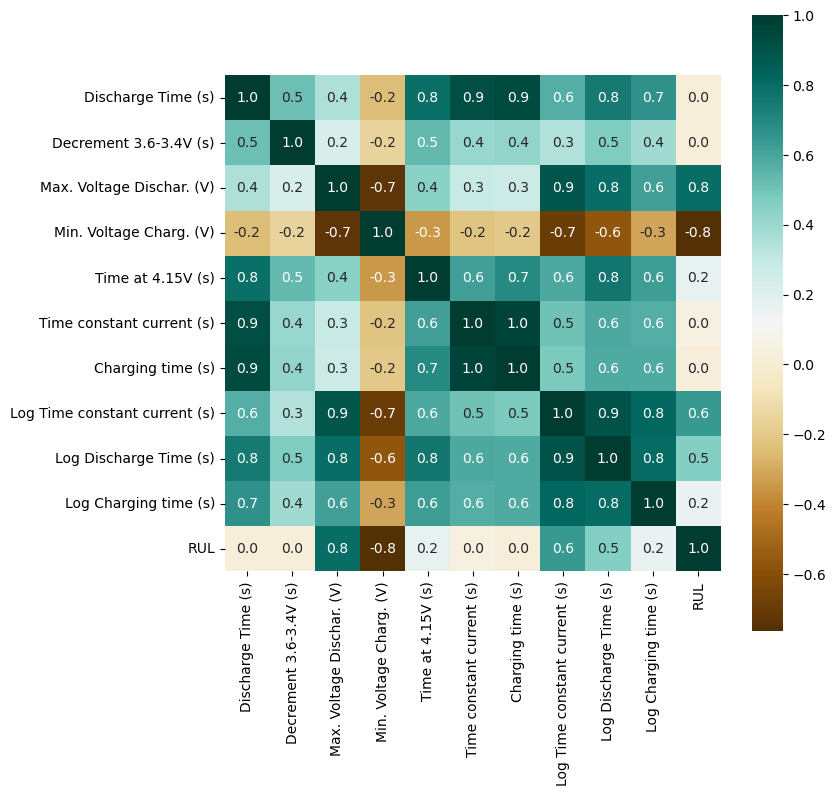

In [1010]:
# When plotting correlations we check for features that are correlated to the target
# variable -> Good candidates for training a model
# as well as features that are highly correlated -> should remove highly correlated
# features to avoid tripping models that expect independent features

# 'Max. Voltage Dischar. (V)' and 'Min. Voltage Charg. (V)' has a pretty strong correlation
# (positive and negative) with the target variable so these look useful.

# We can see that the log transformed features
# - Log Time constant current (s)'
# - Log Discharge Time (s)
# - Log Charging time (s)
# are more correlated with the target than its original feature, perhaps they are easier to use for models
# that are sensitive to outliers
sns.heatmap(data=train.corr(method='pearson'), cmap='BrBG',
            annot=True, square=True, fmt='.1f')
plt.gcf().set_size_inches(w=8, h=8)


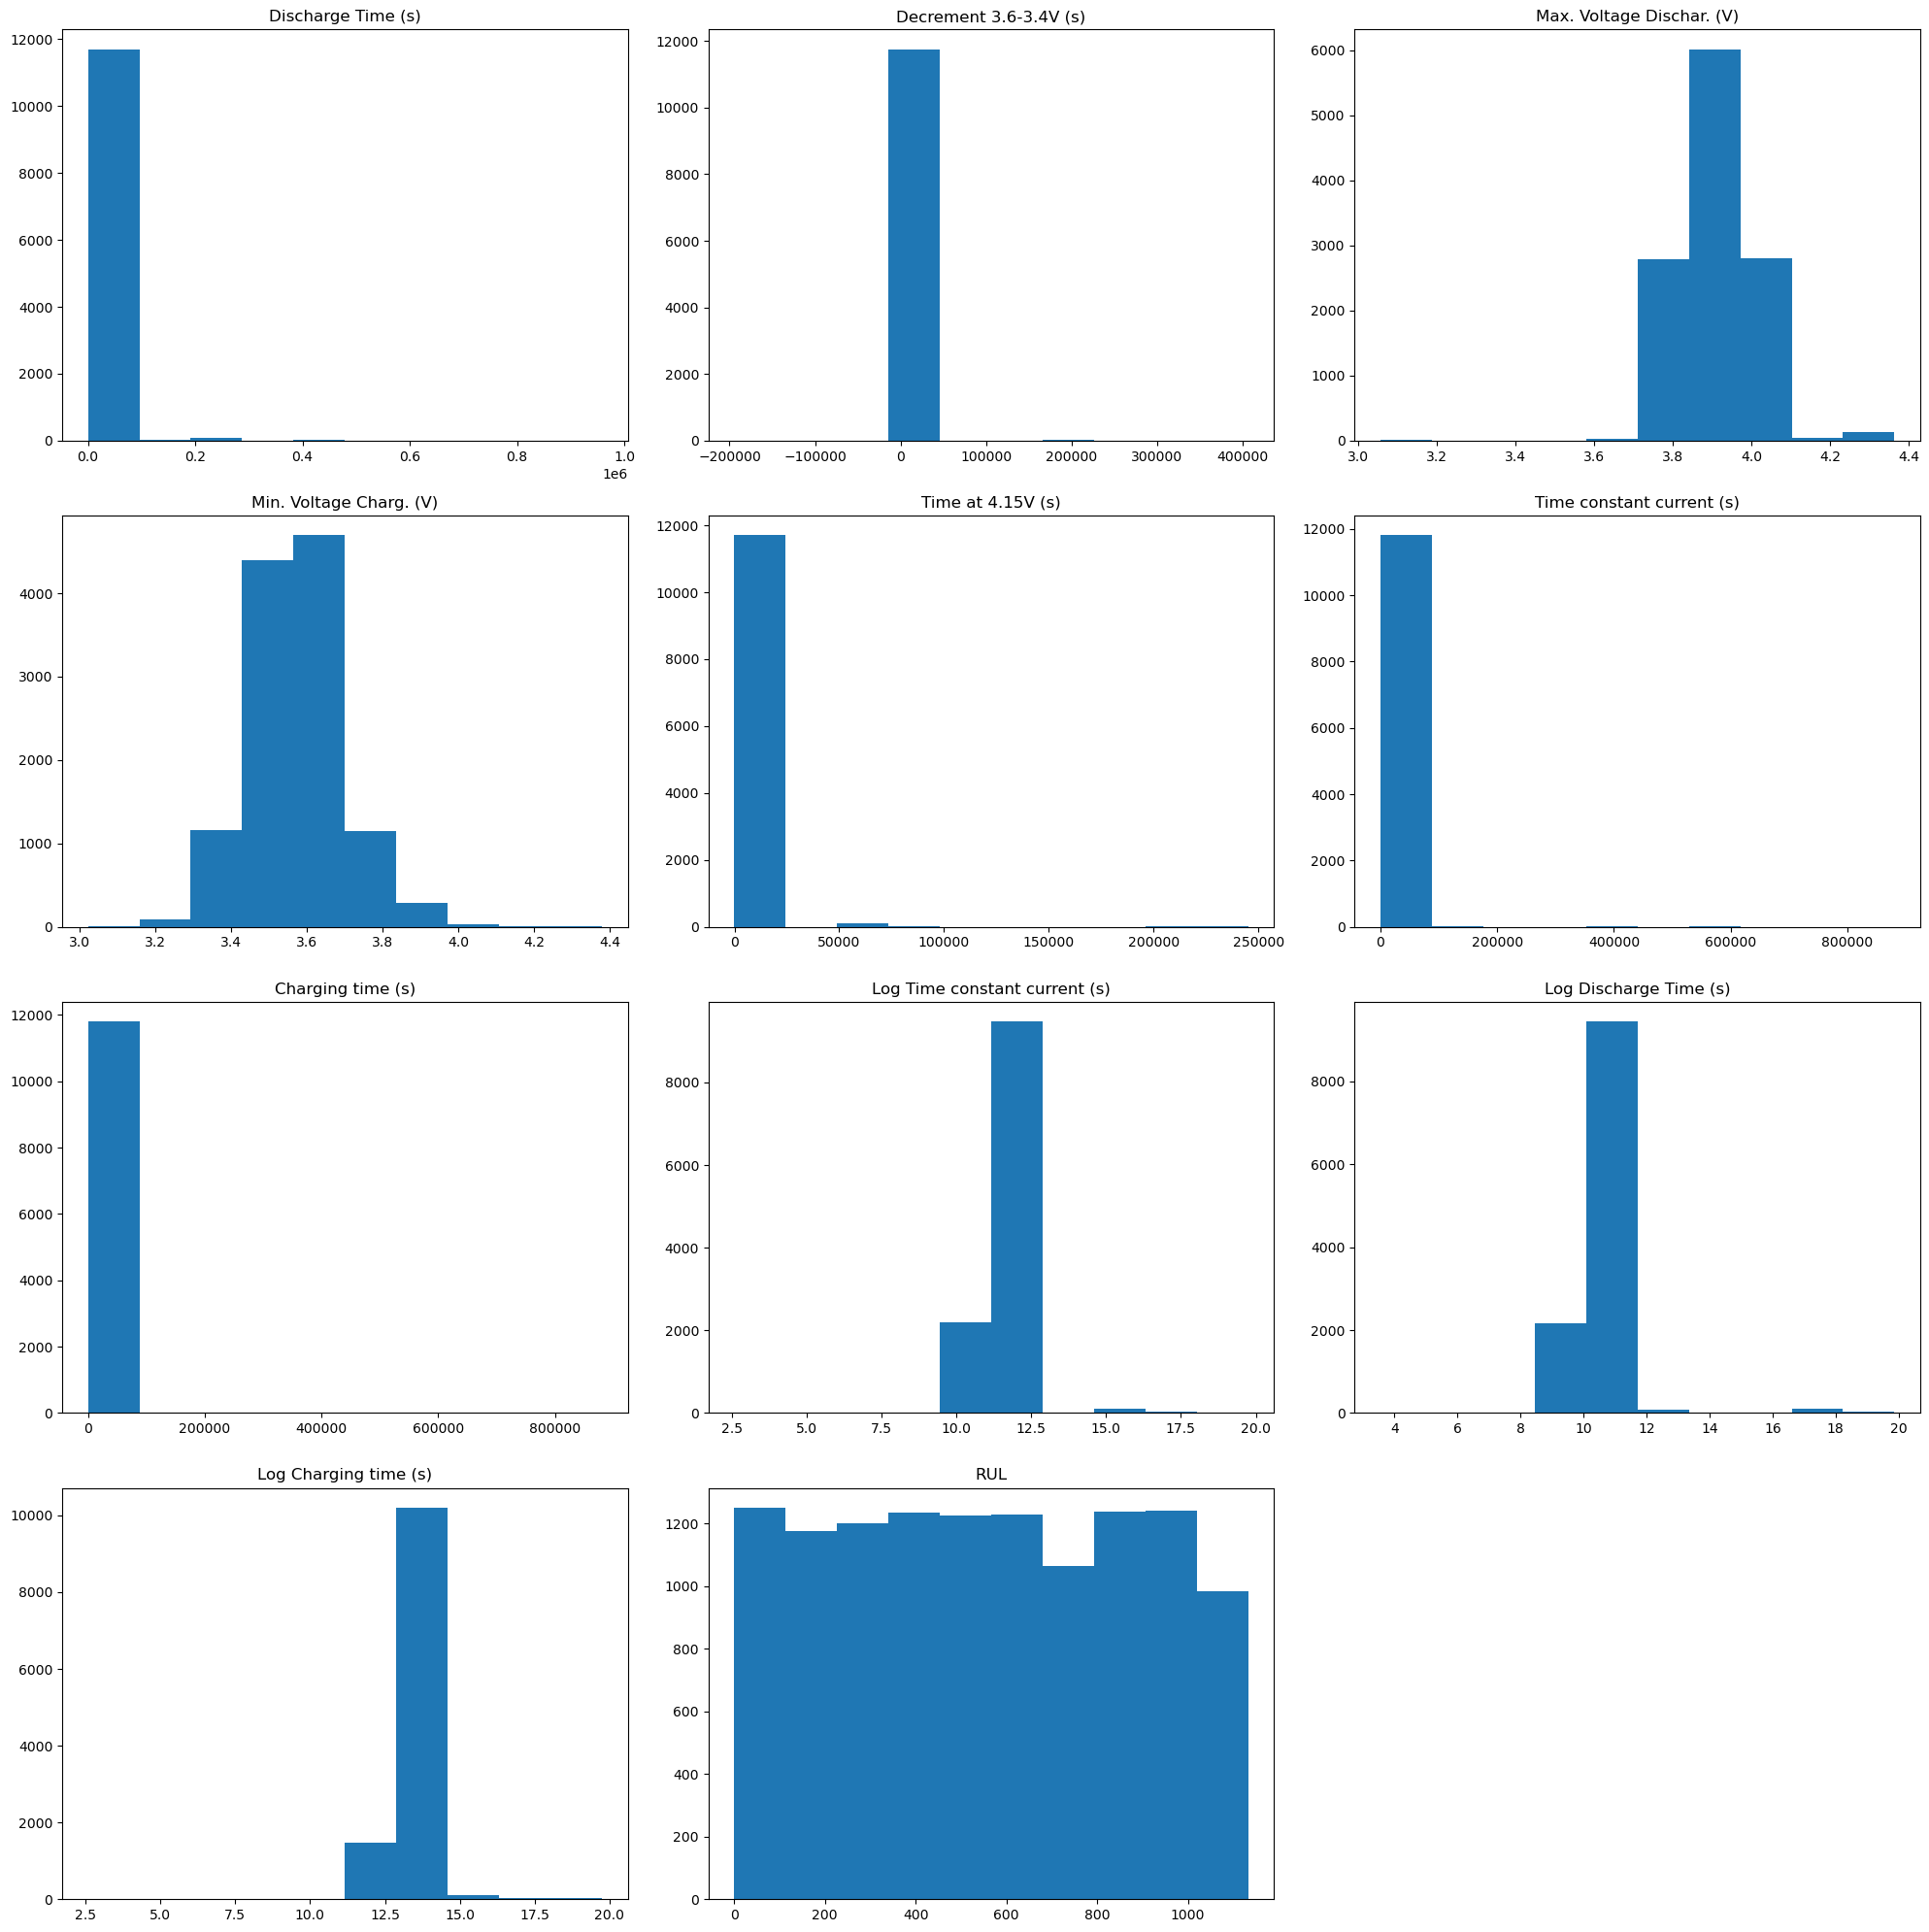

In [1011]:

# Looking at the distributions of the features we can see that 'Min. Voltage Charg. (V)'
# and 'Max. Voltage Dischar. (V)' are the features that are closest to normally distributed
# which should be useful for models.
fig = plt.figure(figsize=(20, 20))
nrows = len(train.columns) // 3 + 1
ncols = 3
for inx, col in enumerate(train.columns):
    plt.subplot(nrows, ncols, inx+1)
    plt.title(col, fontsize=12)
    plt.hist(train[col])

plt.tight_layout()

/Users/jonajoha/miniforge3/envs/rul/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


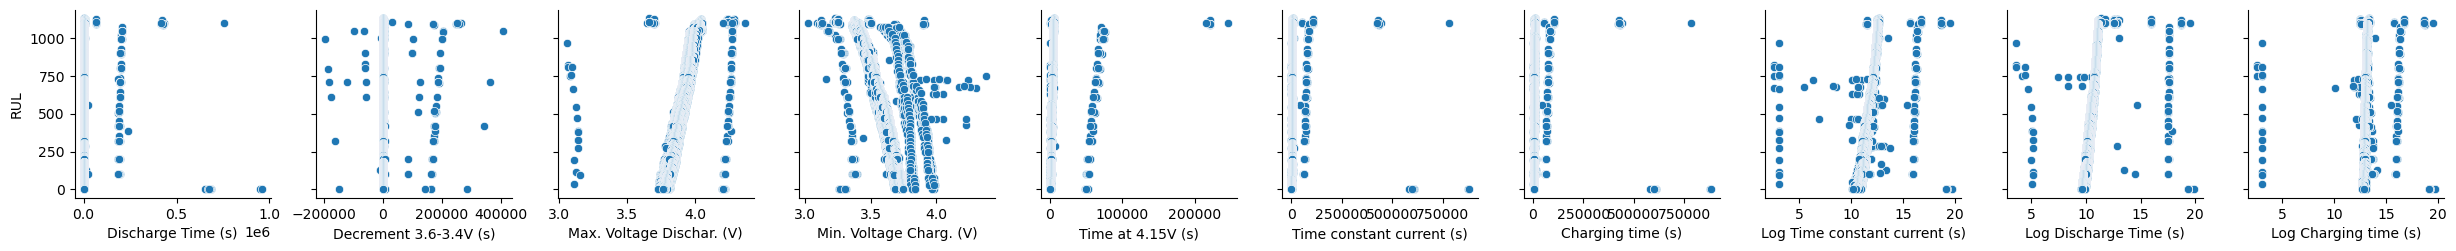

In [1012]:

# From a pairplot we can see that a few features look linearly correlated with the label RUL, but with outliers:
# - 'Max. Voltage Dischar. (V)' is the most correlated feature to the target
# - 'Min. Voltage Charg. (V)' comes in second with a negative correlation to the target
# - 'Log Time constant current (s)' is the third most correlated feature and is one of the log transformed features
# - 'Log Discharge Time (s)' could also be useful but its correlation is 0.9 to Log Time constant current (s) so
# can probably skip it

# Based on this, a linear model could work ok but might need to do something about the outlier. We can use a
# RobustScaler which takes outliers into consideration.
# We could also try other models that are robust to outliers, for example Random Forest and XGBoost.
sns.pairplot(data=train,
             x_vars=[col for col in train.columns if col != label],
             y_vars=[label])


In [1013]:
# From the correlation analysis we pick the following features to use for training
corr_analysis_features = [
    'Min. Voltage Charg. (V)', 'Max. Voltage Dischar. (V)', 'Log Time constant current (s)']


In [1014]:
# Ok, lets compare the perfomance of some models.
# As performance metrics we can use the Root Mean Squared Error (RMSE) and the R2 score.
def calculate_metrics(y, preds):
    r2 = r2_score(y, preds)
    rmse = mean_squared_error(y, preds, squared=False)

    return r2, rmse

In [1015]:
def eval_models(train, test, feature_selections, lbl):
    best_model = None

    for feature_selection in feature_selections:
        features = feature_selection['features']
        name = feature_selection['name']
        print(f"Using {name}.\nFeatures: {', '.join(features)}")

        X_train = train[features]
        y_train = train[lbl]
        X_test = test[features]
        y_test = test[lbl]

        robust_scaler = RobustScaler()
        robust_scaler.fit(X_train)

        X_train_scaled = robust_scaler.transform(X_train)
        X_test_scaled = robust_scaler.transform(X_test)

        # try linear regression
        model = LinearRegression()
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)
        r2 = r2_score(y_true=y_test, y_pred=preds)
        print(f"Linear: R2: {r2}")

        if best_model is None or r2 > best_model['r2']:
            print("New best model!")
            best_model = {
                'model': model,
                'r2': r2
            }

        # try random forest regressor
        model = RandomForestRegressor()
        model.fit(X_train, y_train.to_numpy().ravel())
        preds = model.predict(X_test)
        r2 = r2_score(y_true=y_test, y_pred=preds)
        print(f"Random forest: R2: {r2}")

        if best_model is None or r2 > best_model['r2']:
            print("New best model!")
            best_model = {
                'model': model,
                'r2': r2
            }

        # try xgboost regressor with default hyperparameters
        model = XGBRegressor()
        model.fit(X_train, y_train.to_numpy().ravel())
        preds = model.predict(X_test)
        r2 = r2_score(y_true=y_test, y_pred=preds)
        print(f"XGBoost regressor: R2: {r2}")
        if best_model is None or r2 > best_model['r2']:
            print("New best model!")
            best_model = {
                'model': model,
                'r2': r2
            }
            
        print("")

    return best_model


In [1016]:
def univariate_selection(X_train, y_train, k=3):
    scaler = RobustScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)

    # Select top k features based on f-test
    selector = SelectKBest(f_classif, k=k)

    # Fit to scaled data, then transform it
    selector.fit_transform(X_train_scaled, y_train)
    feature_idx = selector.get_support()
    feature_names = X_train.columns[feature_idx]

    return feature_names

univariate_selection_features = univariate_selection(
    X_train=train.drop(label, axis=1),
    y_train=train[label],
    k=3
)

In [1017]:
def feature_importance_selection(X_train, y_train, k=4):
    random_forest_model = RandomForestRegressor()
    random_forest_model.fit(X_train, y_train.to_numpy().ravel())
    top_indices = np.argsort(a=-random_forest_model.feature_importances_).tolist()[:k]
    feature_names = X_train.columns[top_indices]
    return feature_names


feature_importance_features = feature_importance_selection(
    X_train=train.drop(label, axis=1),
    y_train=train[label],
    k=3
)

In [1018]:
feature_selections = [
    {
        "name": "Correlation Analysis Selection",
        "features": corr_analysis_features
    },
    {
        "name": "Univariate Selection",
        "features": univariate_selection_features
    },
    {
        "name": "Feature Importance Selection",
        "features": feature_importance_features
    },
]

best_model = eval_models(train=train, test=test, feature_selections=feature_selections, lbl=label)

Using Correlation Analysis Selection.
Features: Min. Voltage Charg. (V), Max. Voltage Dischar. (V), Log Time constant current (s)
Linear: R2: 0.6856713213603847
New best model!
Random forest: R2: 0.962372761425052
New best model!
XGBoost regressor: R2: 0.9639267607378957
New best model!

Using Univariate Selection.
Features: Max. Voltage Dischar. (V), Min. Voltage Charg. (V), Charging time (s)
Linear: R2: 0.6912910279324045
Random forest: R2: 0.9545735160894518
XGBoost regressor: R2: 0.9601591807113998

Using Feature Importance Selection.
Features: Discharge Time (s), Log Discharge Time (s), Decrement 3.6-3.4V (s)
Linear: R2: 0.3533858636743771
Random forest: R2: 0.9610489558995233
XGBoost regressor: R2: 0.9680000578378919
New best model!



In [1019]:
best_model


{'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...),
 'r2': 0.9680000578378919}